<a href="https://colab.research.google.com/github/Onmang/Multimedia_engineering/blob/master/T20ME022_ex0526.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.models import Model

import numpy as np
import cv2 # opencv 
import matplotlib.pyplot as plt # 画像の描画ためのライブラリ
tf.test.gpu_device_name() # GPUの利用確認

'/device:GPU:0'

In [2]:
mnist = tf.keras.datasets.mnist # MNISTデータを使う。TensorFlowにはMNIST用のライブラリが用意されている
# MNISTデータをネットからロードする。
# 訓練用60000枚，検証用10000枚。予め分けられている。
(x_train, y_train), (x_valid, y_valid) = mnist.load_data()

11490434/11490434 [==============================] - 2s 0us/step


In [3]:
# データ変換（正規化とテンソル変換）
def convert_data(x, y):
    x = tf.expand_dims(x, axis=-1)
    x = tf.cast(x, tf.float32) # float32に変換
    x /= 255. # 255で割って正規化    
    return x, y

#
# tf.Dataを使った tf.Tensor変換
#
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)) # 訓練セットの入力と教師ラベル合体させてTensorに変換
valid_ds = tf.data.Dataset.from_tensor_slices((x_valid, y_valid)) # 検証も同様に処理
AUTOTUNE = tf.data.experimental.AUTOTUNE # 処理を最適化するためのおまじない（自動チューニング設定）

train_ds = train_ds.shuffle(len(x_train)) # 訓練データをシャッフルする。引数にはデータ数を指定すると完全なシャッフルが行われる。len(x_train)は60000。
train_ds = train_ds.repeat(1) # 1 epochで使われるデータの回数。1の場合，1epochで1回しか使われない。引数を空欄にすると無限に使われる。
train_ds = train_ds.batch(50) # ミニバッチを作る。1バッチ50個のデータ。
# train_ds = train_ds.map(lambda x, y: tf.py_function(convert_data, [x, y], Tout=[tf.float32, tf.int32])) # データ変換。py_function + ラムダ式を使う場合
train_ds = train_ds.map(convert_data, num_parallel_calls=AUTOTUNE) # データ変換。今回はpy_functionは不要なので，map関数のみで対応
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE) # 訓練中に次のバッチを取り出すための処理。

valid_ds = valid_ds.batch(50) # 検証データはシャッフルする必要ないので，バッチ化のみの処理でOK。
valid_ds = valid_ds.map(convert_data, num_parallel_calls=AUTOTUNE)

In [7]:
# パディングなしバージョン
input = Input(shape=(28, 28, 1), name='input') # 入力層の定義　28×28×1
h = Conv2D(32, (5, 5), activation='relu', name='cnn01')(input) # フィルタ数32，フィルタサイズ5x5→単に5と書いてもOK
h = MaxPooling2D((2, 2), name='pool01')(h) # 最大値プーリングで特徴マップを半分にする
h = Conv2D(64, (5, 5), activation='relu', name='cnn02')(h)
h = MaxPooling2D((2, 2), name='pool02')(h)
h = Flatten(name='flatten')(h) # 特徴マップをフラット化する
h = Dense(256, activation='relu', name='dense01')(h) # 全結合層の隠れ層のノードは256
output = Dense(10, activation='softmax', name='output')(h) # 出力層（10次元）

cnn_model = Model(inputs=input, outputs=output) 
cnn_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 28, 28, 1)]       0         
                                                                 
 cnn01 (Conv2D)              (None, 24, 24, 32)        832       
                                                                 
 pool01 (MaxPooling2D)       (None, 12, 12, 32)        0         
                                                                 
 cnn02 (Conv2D)              (None, 8, 8, 64)          51264     
                                                                 
 pool02 (MaxPooling2D)       (None, 4, 4, 64)          0         
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense01 (Dense)             (None, 256)               2624

In [18]:
cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy']) # 損失と評価尺度の設定

In [20]:
cnn_model.fit(train_ds, epochs=10, validation_data=valid_ds) # エポック数は10くらいで十分

Epoch 1/10
1200/1200 [==============================] - 7s 4ms/step - loss: 0.0071 - accuracy: 0.9977 - val_loss: 0.0305 - val_accuracy: 0.9936
Epoch 2/10
1200/1200 [==============================] - 6s 5ms/step - loss: 0.0056 - accuracy: 0.9982 - val_loss: 0.0344 - val_accuracy: 0.9926
Epoch 3/10
1200/1200 [==============================] - 7s 6ms/step - loss: 0.0044 - accuracy: 0.9985 - val_loss: 0.0407 - val_accuracy: 0.9918
Epoch 4/10
1200/1200 [==============================] - 6s 4ms/step - loss: 0.0057 - accuracy: 0.9982 - val_loss: 0.0328 - val_accuracy: 0.9925
Epoch 5/10
1200/1200 [==============================] - 6s 5ms/step - loss: 0.0049 - accuracy: 0.9986 - val_loss: 0.0437 - val_accuracy: 0.9912
Epoch 6/10
1200/1200 [==============================] - 6s 5ms/step - loss: 0.0035 - accuracy: 0.9990 - val_loss: 0.0486 - val_accuracy: 0.9907
Epoch 7/10
1200/1200 [==============================] - 5s 4ms/step - loss: 0.0045 - accuracy: 0.9986 - val_loss: 0.0539 - val_accuracy:

(10, 28, 28, 1)


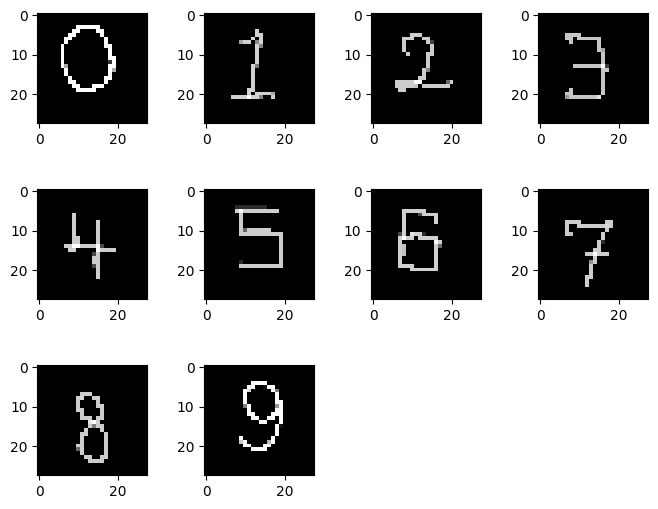

In [27]:
#
# 10個まとめて表示＆推論するコード （拡張子がjpgの場合）
#  0.jpg〜9.jpgの10個のファイルを用意しておくこと
#
data = []
plt.figure(figsize=(8, 6)) # 10枚並べて描画するために描画するキャンバスを用意
plt.subplots_adjust(wspace=0.4, hspace=0.6) # 画像同士の間隔の調整
for i in range(10):
    file =  '/content/'+ str(i) + '.png' # ファイル名
    img = cv2.imread(file, cv2.IMREAD_GRAYSCALE) # 画像データを読み込む
    img = cv2.resize(img, (28, 28)) # 28x28にリサイズ
    img = 255 - img  # 白黒反転
    plt.subplot(3, 4, i+1) # キャンバスを3行4列の12マスに分割。i+1番目のマスに描画
    plt.imshow(img, cmap='gray') # 実際の描画処理
    data.append(img.reshape(28, 28, 1) / 255.) # 1ch追加し，255で割って正規化
data = np.array(data, dtype=np.float32) # NNの入力データ。(10, 28, 28, 1)の4次元テンソルになっている
print(data.shape) # データの形の確認

1/1 [==============================] - 0s 19ms/step
正答率 = 100.0%


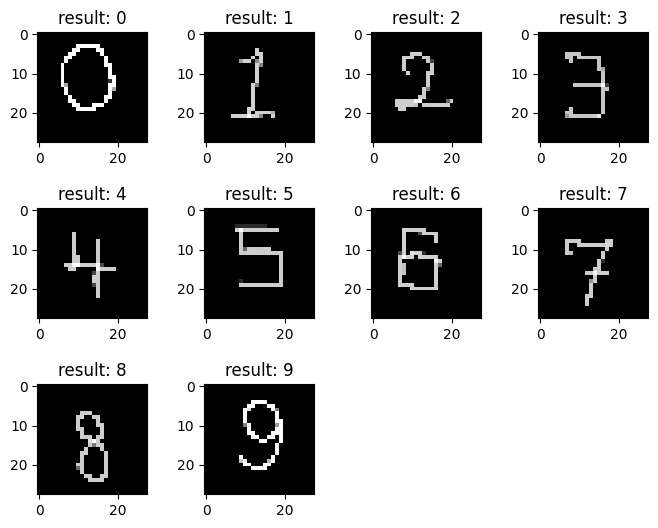

In [39]:
predictions = cnn_model.predict(data) # predict関数で10個のデータを同時に推論（バッチ処理）
result = predictions.argmax(axis=1) # argmax関数で一番確率が高い結果を取得
plt.figure(figsize=(8, 6))
plt.subplots_adjust(wspace=0.4, hspace=0.6) # 画像同士の間隔の調整
j = 0
for i in range(10):
    file = '/content/'+ str(i) + '.png'
    img = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (28, 28))
    img = 255 - img  # 白黒反転
    plt.subplot(3, 4, i+1)
    plt.title(f'result: {result[i]}') # 推論結果を表示（グラフのタイトルにしている）
    plt.imshow(img, cmap='gray')
    if result[i] == i:
      j += 1

acr = (j/10)*100
print(f'正答率 = {acr}%')

# 正解率を表示させるコードを上記に追加せよ。